In [1]:
### SPARK imports

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql import Window

from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler


In [2]:
### Regular python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import getpass
%matplotlib inline

In [3]:
#Set the paths here!

user = getpass.getuser()
if user == "sidsel":
    parquet = "/home/"+user+"/workspace/sparkdata/parquet/"
    regnskabsData = "alleregnskaber.parquet"
    cvrData = "virkdata.parquet"
    csvpath = "/home/"+user+'/workspace/sparkdata/csv'

elif user == "svanhmic":
    cvrParquetPath = "/home/"+user+"/workspace/Python/Erhvervs/data/cdata/parquet/"
    regnskabParquetPath = "/home/"+user+"/workspace/Python/Erhvervs/data/regnskabsdata/sparkdata/parquet/" 
    csvpath = "/home/"+user+'/workspace/Python/Erhvervs/data/regnskabsdata'

In [4]:
zeroYearWindow = Window.partitionBy("cvr")
laggValueWindow = Window.partitionBy("cvr").orderBy("End_Instant")

In [5]:
#import data and do transformations

iktBrancheDf = sqlContext.read.parquet(cvrParquetPath+"IktBrancher.parquet").cache()
notIktGazelleDf = sqlContext.read.parquet(cvrParquetPath+"IktNotGazeller.parquet")
iktGazelleDf = sqlContext.read.parquet(cvrParquetPath+"IktGazeller.parquet")

largeGap = F.lag(F.col("Year"),1,0).over(laggValueWindow)-F.col("Year")

notReallyGazelleDf = (iktGazelleDf
                .withColumn("Year",F.year(F.col("End_Instant")))
                .withColumn("gap",largeGap)
                .withColumn("isGap",F.when((largeGap >= -1) | (largeGap <= -2000),True).otherwise(False))
                .filter(F.col("isGap") == False)
                .select("cvr")
                .distinct()
               )

iktGazelleDf = (iktGazelleDf
                .select("cvr")
                .distinct()
                .subtract(notReallyGazelleDf)
                .join(iktGazelleDf,("cvr"),"inner")
                .cache()
               )


notIktGazelleDf = (notIktGazelleDf
                   .drop("rank")
                   .withColumn("GrossResult",F.col("GrossResult").cast("double"))
                   .withColumn("Revenue",F.col("Revenue").cast("double"))
                   .withColumn("LaggedGrossResult",F.col("GrossResult")-F.lag(F.col("GrossResult")).over(laggValueWindow))
                   .filter(F.col("LaggedGrossResult") >= 0.0)
                   .withColumn("FirstRevenue",F.when(F.col("Revenue") >= 1000000,True).otherwise(False))
                   .withColumn("FirstGrossResult",F.when(F.col("GrossResult") >= 500000,True).otherwise(False))
                   .filter((F.col("FirstGrossResult")==True) | (F.col("Revenue")==True))
                   .withColumn("Year", F.rank().over(laggValueWindow).cast("double")-1)
                   .withColumn("maxRank",F.max("Year").over(zeroYearWindow).cast("double"))
                   .filter(F.col("maxRank") >= 3) # re want to predict for at least four values
                   .drop("maxRank")
                   #.filter(F.col("cvr") == 10008123)
                   .cache()
               )

print("Number of Non-Gazell points: "+str(notIktGazelleDf.count()))
print("Number of Non-Gazell cvr-numbers: "+str(notIktGazelleDf.select("cvr").distinct().count()))
print("Number of Gazell points: "+str(iktGazelleDf.count()))
print("Number of Gazells cvr-numbers: "+str(iktGazelleDf.select("cvr").distinct().count()))


#How  many are there in each IKT-subbranche for cvrs with more than a mio or half mio? 
(notIktGazelleDf
 .select("cvr","branchekode","Branchenavn")
 .distinct()
 .groupBy("Branchenavn","branchekode")
 .count()
 .show(truncate=False))

Number of Non-Gazell points: 672
Number of Non-Gazell cvr-numbers: 110
Number of Gazell points: 364
Number of Gazells cvr-numbers: 95
+-----------------------------------------------------+-----------+-----+
|Branchenavn                                          |branchekode|count|
+-----------------------------------------------------+-----------+-----+
|Engroshandel med elektronisk udstyr                  |465210     |6    |
|Computer facility management                         |620300     |2    |
|Fastnetbaseret telekommunikation                     |611000     |11   |
|Fremstilling af elektronik til husholdninger         |264000     |1    |
|Engroshandel med computere, ydre enheder og software |465100     |21   |
|Databehandling, webhosting og lignende serviceydelser|631100     |5    |
|Reparation af kommunikationsudstyr                   |951200     |1    |
|Fremstilling af kommunikationsudstyr                 |263000     |3    |
|Anden udgivelse af software                        

In [6]:
commomCols = ["cvr",F.year("End_Instant").cast("double").alias("year")
              ,F.log1p("GrossResult").alias("GrossResult")
              ,F.log1p("GrossProfitLoss").alias("GrossProfitLoss")
              ,F.log1p("Revenue").alias("Revenue")
              ,"branchetekst","Standardgruppering_19"]

notIktGazelle2Df = (notIktGazelleDf
                    .select(commomCols)
                    .withColumn("isGazelle",F.lit("candidate Gazelle"))
                   )
#notIktGazelle2Df.printSchema()
iktGazelleCandidatesDf = (iktBrancheDf
                 .join(iktGazelleDf.select("cvr").distinct(),("cvr"),"inner")
                 .select(commomCols)
                 .withColumn("isGazelle",F.lit("Gazelle"))
                )
iktGazelleCandidatesDf.printSchema()

unionGazellsDf = notIktGazelle2Df.unionAll(iktGazelleCandidatesDf)


iktNonCandidatesDf = (iktBrancheDf
                      .select("cvr")
                      .distinct()
                      .subtract(unionGazellsDf.select("cvr").distinct())
                      .join(iktBrancheDf,("cvr"),"inner")
                      .select(commomCols)
                      .withColumn("isGazelle",F.lit("Other"))
                     )
iktNonCandidatesDf.count()

totalIktUnionDf = iktNonCandidatesDf.unionAll(unionGazellsDf)

root
 |-- cvr: integer (nullable = true)
 |-- year: double (nullable = true)
 |-- GrossResult: double (nullable = true)
 |-- GrossProfitLoss: double (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- branchetekst: string (nullable = true)
 |-- Standardgruppering_19: string (nullable = true)
 |-- isGazelle: string (nullable = false)



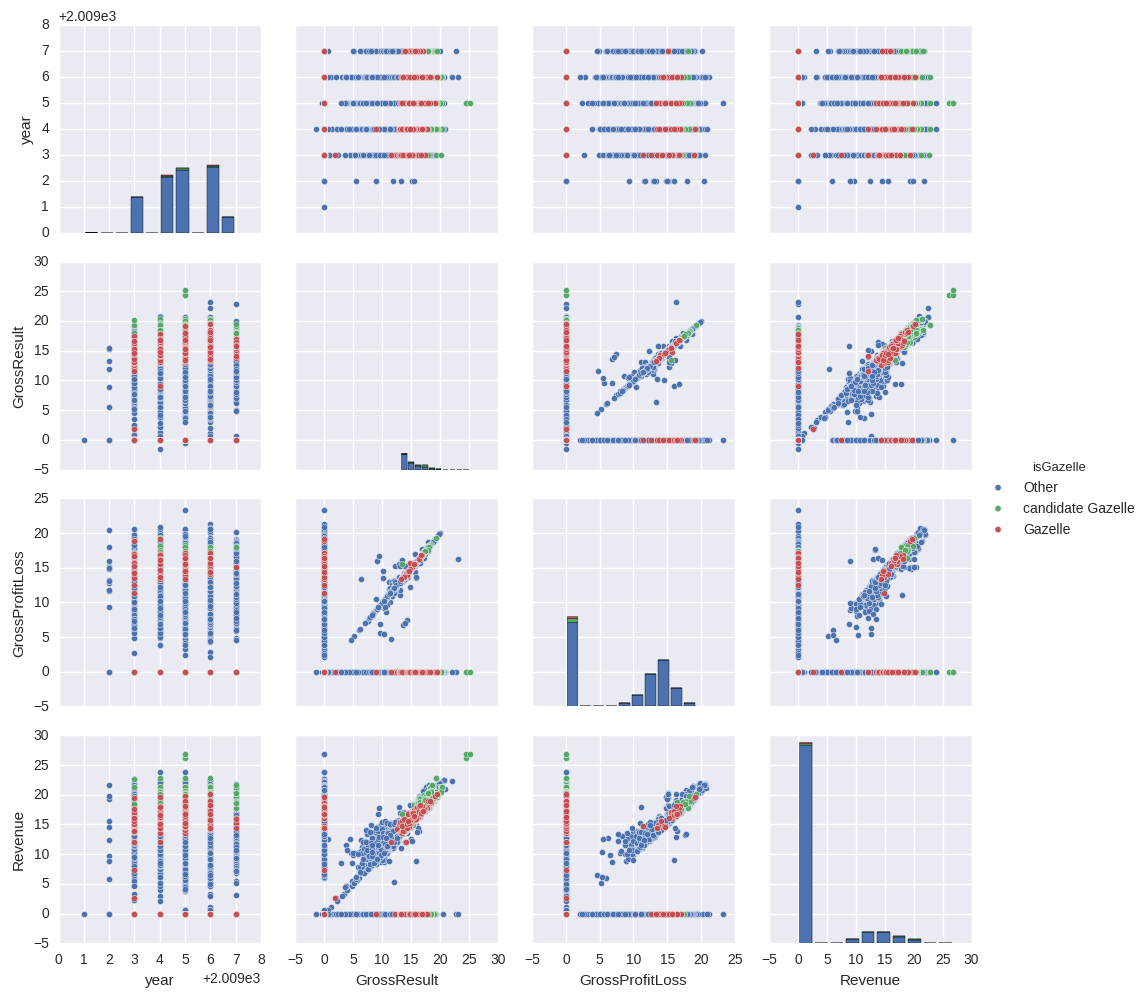

In [7]:
### All years combined
axes = sb.pairplot(totalIktUnionDf.drop("cvr").drop("branchetekst").drop("Standardgruppering_19").toPandas(),hue="isGazelle")
plt.show()

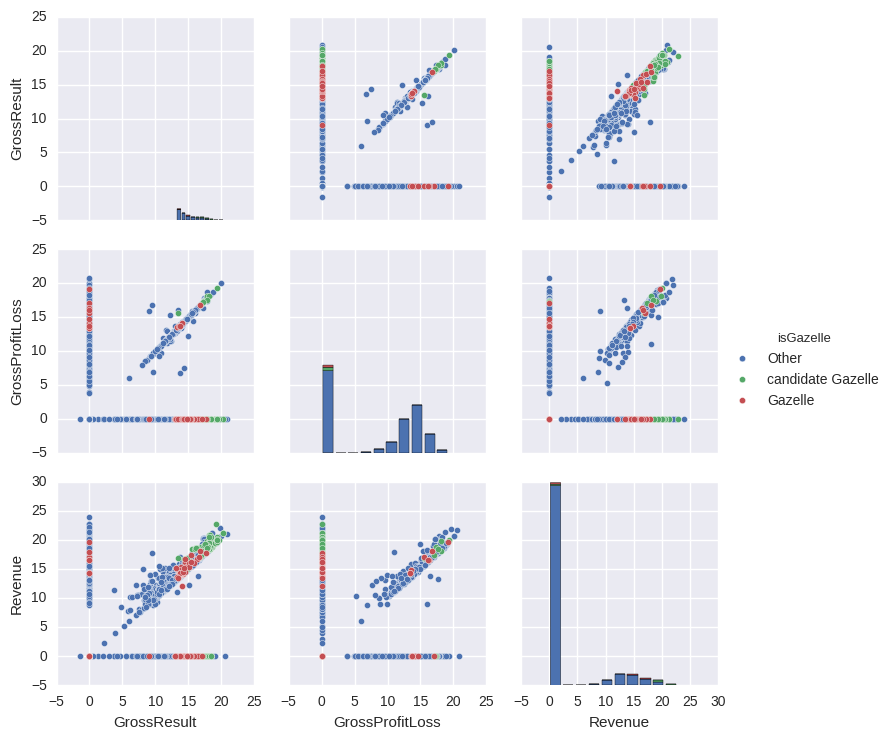

In [8]:
sb.pairplot(totalIktUnionDf.filter(F.col("Year")==2013).drop("cvr").drop("Year").drop("branchetekst").drop("Standardgruppering_19").toPandas(),hue="isGazelle")
plt.show()

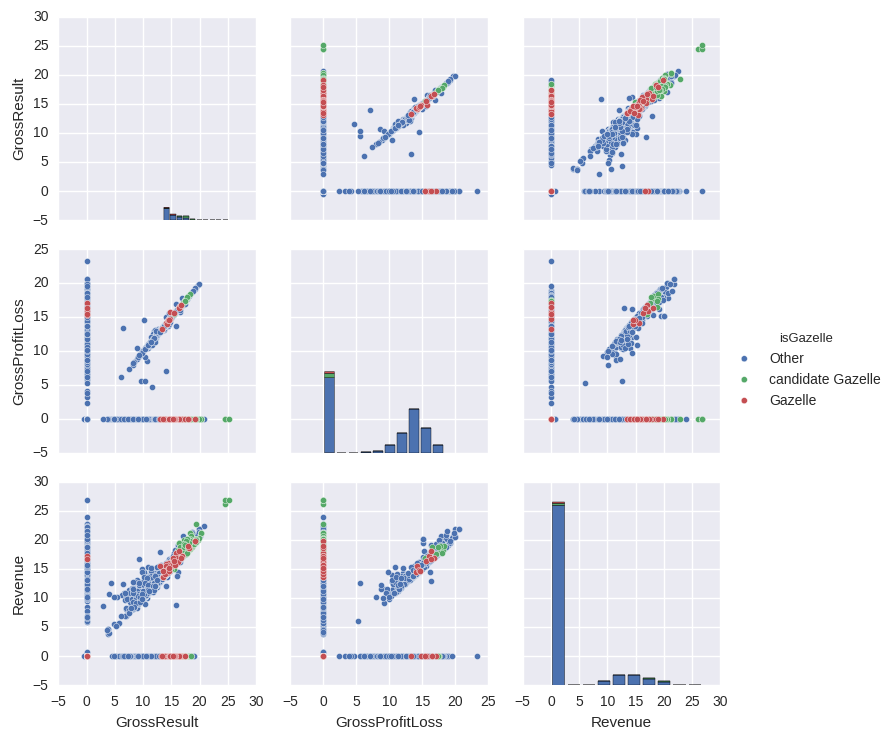

In [9]:
sb.pairplot(totalIktUnionDf.filter(F.col("Year")==2014).drop("cvr").drop("Year").drop("branchetekst").drop("Standardgruppering_19").toPandas(),hue="isGazelle")
plt.show()

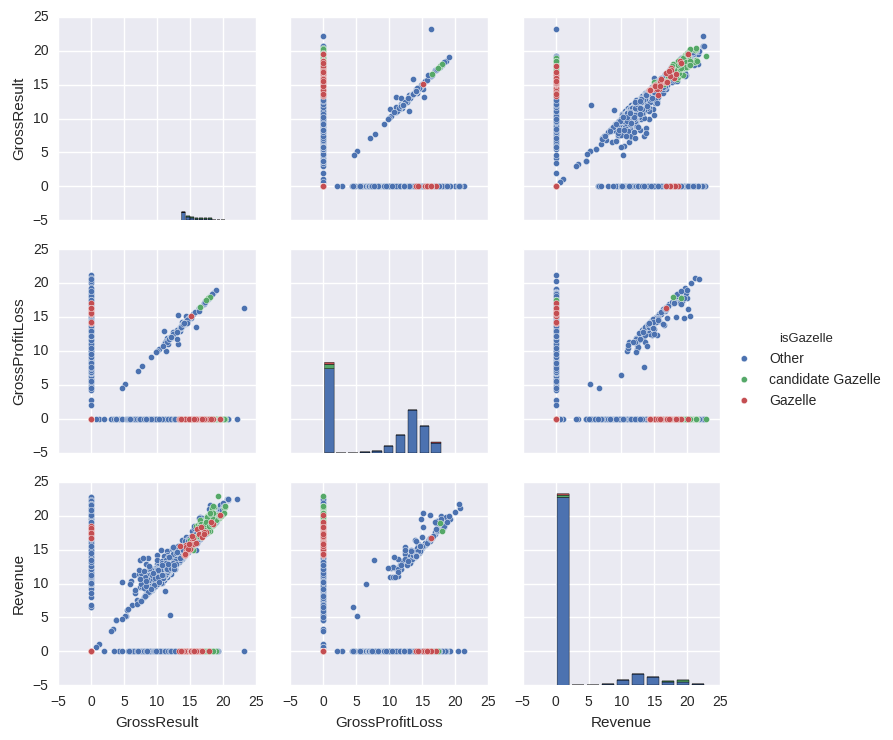

In [10]:
sb.pairplot(totalIktUnionDf.filter(F.col("Year")==2015).drop("cvr").drop("Year").drop("branchetekst").drop("Standardgruppering_19").toPandas(),hue="isGazelle")
plt.show()

In [11]:
#Show a subsample brancher for revenue and Gross Result 
pandasNotGazeller = (notIktGazelleDf
                     .select("cvr","branchekode","Branchenavn","GrossResult","Revenue",F.year(F.col("End_Instant")).alias("Year"))
                     .filter((F.col("branchekode") == 620100) | (F.col("branchekode") == 620200) )
                     .toPandas()
                    )

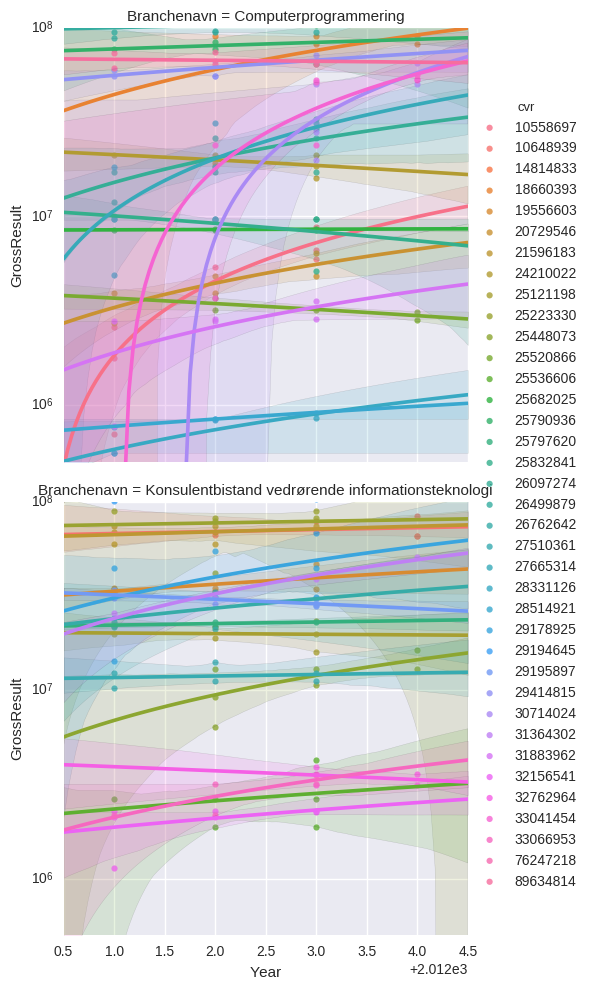

In [12]:


ax = sb.lmplot("Year","GrossResult",pandasNotGazeller,fit_reg=True,hue="cvr",sharex=True,logx=True,legend=True,size=5,row="Branchenavn")
#ax.map(plt.plot,"Year","GrossResult")
ax.set(yscale="log")
ax.set(ylim=[500000,100000000])
plt.show()

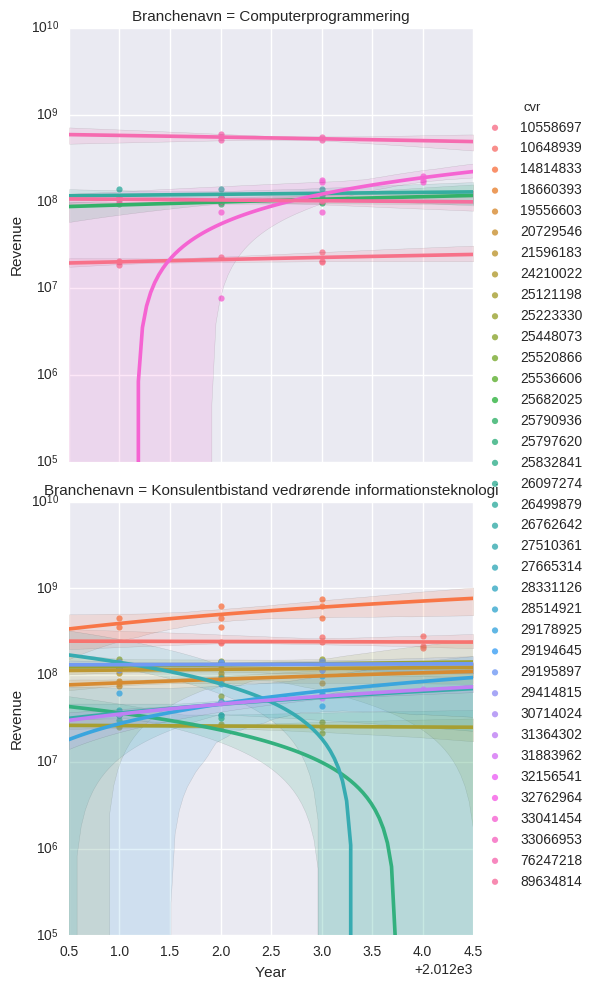

In [13]:
ax2 = sb.lmplot("Year","Revenue",pandasNotGazeller,fit_reg=True,hue="cvr",sharex=True,logx=False,legend=True,size=5,row="Branchenavn")
#ax.map(plt.plot,"Year","GrossResult")
ax2.set(yscale="log")
plt.show()

In [14]:
#Build the pipeline here!


vecAss = VectorAssembler(inputCols=["Year"],outputCol="features")
lg = LinearRegression(labelCol="GrossResult",regParam=0.1,elasticNetParam=0.1)
pipeGro = Pipeline(stages=[vecAss,lg])

lg2 = LinearRegression(labelCol="Revenue",regParam=0.1,elasticNetParam=0.1)
pipeRev = Pipeline(stages=[vecAss,lg2])

In [15]:
paramGrid = (ParamGridBuilder()
             .baseOn({lg.maxIter:10})
             
             .baseOn({lg.featuresCol:vecAss.getOutputCol()})     
             .addGrid(lg.elasticNetParam, [0.5])
             .addGrid(lg.regParam,[0.1])
             .build())


crossvalGro = CrossValidator(estimator=pipeGro,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

In [16]:
def executeLinearRegressionsYearVar(df,targetCol,crossval,maxYear=6):
    """
        this method should do linear regression for 
        each of the companies or another column that we can chose. 
    """
    
    #Extract unqiue cvr-numbers
    uniqueTargetValues = (df
                          .select(targetCol)
                          .distinct()
                          .rdd
                          .map(lambda x: x[0])
                          .collect()
                         )
    
    modelsPrCvr = {} # add all models with cvr numbers in this one.
    
    #yearDf = sqlContext.range(1,maxYear).withColumnRenamed("id","Year").cache()
    
    #Run through all cvr-numbers
    for company in uniqueTargetValues:
        try:
            tempDf = df.filter(F.col(targetCol) == company)
            #tempDf.show(5)
            if tempDf.count() < 3:
                print("this should not happen: "+str(tempDf.count()))
            else:
                model = crossval.fit(tempDf) # create model             
                
                modelsPrCvr[company] = model
        except:
            tempDf.show()
            #tempDf.printSchema()
            #break

    
    return modelsPrCvr
    
def evaluateAllModels(df,colName,dict,evaluator):
    """
        this method should do linear regression for 
        each of the companies or another column that we can chose. 
    """
    
    
    yearDf = sqlContext.range(0,6).withColumnRenamed("id","Year").cache()
    dictDf = {}
    if colName == "cvr":
        for idx,val in dict.items():

            tempDf = df.filter(F.col(colName) == idx)
            prediction = val.transform(tempDf)

            dictDf[idx] = (evaluator.evaluate(prediction),val.transform(yearDf),hasIncreasedtoDouble(val.transform(yearDf)))
    else:
        cvrs = df.select("cvr",colName).distinct().rdd.flatMap(lambda x: x).collect()
        
        predictions = {}
        
        for idx,val in dict.items():
            predictions[idx] = val.transform(yearDf).cache()
        
        for (idx,val) in cvrs:
            
            tempDf = df.filter(F.col("cvr") == idx)
            model = dict[val]
            prediction = model.transform(tempDf)

            dictDf[idx] = (evaluator.evaluate(prediction),predictions[val],hasIncreasedtoDouble(predictions[val]))

            
    return dictDf




def hasIncreasedtoDouble(prediction,startYear=0,endYear=4):
    """
        returns try or false to wheter if a company has more than doubled its size in revenue or grossResult
    """
    
    zeroVal = prediction.filter(F.col("Year") == startYear).collect()[0]["prediction"]
    endVal = prediction.filter(F.col("Year") == endYear).collect()[0]["prediction"]
    if endVal >= (zeroVal*2):
        return True
    else: 
        return False
    

In [17]:
print("entire IKT: " + str(iktBrancheDf.count()))
print("gazels in IKT: " + str(iktGazelleDf.count()))
print("Non-gazels in IKT: " + str(notIktGazelleDf.count()))

entire IKT: 41410
gazels in IKT: 364
Non-gazels in IKT: 672


In [18]:
#notIktGazelleDf.show()

In [19]:
# Run cross-validation, and choose the best set of parameters.
allModelsRev = executeLinearRegressionsYearVar(notIktGazelleDf,"cvr",pipeRev)
allModelsGro = executeLinearRegressionsYearVar(notIktGazelleDf,"cvr",pipeGro)

In [20]:
regressionEvaluatorGro = RegressionEvaluator(predictionCol="prediction",labelCol="GrossResult",metricName="rmse")
regressionEvaluatorRev = RegressionEvaluator(predictionCol="prediction",labelCol="Revenue",metricName="rmse")


In [21]:
modelsDictRev = evaluateAllModels(notIktGazelleDf,"cvr",allModelsRev,regressionEvaluatorRev)
modelsDictGro = evaluateAllModels(notIktGazelleDf,"cvr",allModelsGro,regressionEvaluatorGro)

In [22]:
filtered_Rev = {k:v for (k,v) in modelsDictRev.items() if v[2] == True}
filtered_Gross = {k:v for (k,v) in modelsDictGro.items() if v[2] == True}

In [23]:
#predicted Gazeller for IKT GrossResult
filtered_Gross
    

{10558697: (954511.0842002091,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 27665314: (6390531.500507165,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 28313160: (5173018.241048666,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 29240817: (1813700.3341474808,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 30714024: (11028163.044375675,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 31364302: (1699015.7602548334,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 33041454: (11359700.04294252,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True)}

In [24]:
#predicted Gazeller for IKT Revenue
filtered_Rev

{10008123: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 10510732: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 13248699: (131049026.44266193,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 13449848: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 14712984: (857860.4027394229,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15116498: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15202513: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15401281: (68449769.38319084,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 18660393: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 19189635: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 20172800: (0.0,
  DataFrame[Year: bigint, feat

In [25]:
### regression pr branche? 

In [26]:
allModelsForBrancheRev = executeLinearRegressionsYearVar(notIktGazelleDf,"branchekode",pipeRev)
allModelsForBrancheGro = executeLinearRegressionsYearVar(notIktGazelleDf,"branchekode",pipeGro)
#allModelsGro = executeLinearRegressionsYearVar(notIktGazelleDf,"cvr",pipeGro)

In [27]:

modelsDictRevBrancher = evaluateAllModels(notIktGazelleDf,"branchekode",allModelsForBrancheRev,regressionEvaluatorRev)
modelsDictGroBrancher = evaluateAllModels(notIktGazelleDf,"branchekode",allModelsForBrancheGro,regressionEvaluatorGro)


filtered_RevBrancher = {k:v for (k,v) in modelsDictRevBrancher.items() if v[2] == True}
filtered_GrossBrancher = {k:v for (k,v) in modelsDictGroBrancher.items() if v[2] == True}

TypeError: 'int' object is not iterable

In [ ]:
notIktGazelleDf.show()

In [ ]:
def containsConsolidated(arr):
    if 

In [ ]:
debtCols = ["Name",F.col("EntityIdentifier").alias("cvr"),F.year("End_Instant").alias("Year"),"Value","Dimensions"]

In [ ]:
debtDf = (sqlContext
          .read
          .parquet(regnskabParquetPath+"regnskaberDebt.parquet")
          .select(debtCols)
          .select("*",F.explode("Dimensions").alias("stringDim"))
          .withColumn("stringDim",F.regexp_extract("stringDim",r"(Consolidated)",0))
          #.filter(F.col("stringDim") == "")
          .drop("stringDim")
          .drop("Dimensions")
          .dropDuplicates()
          .withColumn("Value",F.log1p(F.regexp_replace("Value","[,]","").cast("double")))
          .withColumn("Name",F.regexp_replace("Name",r'\w+:',''))
          .groupBy("cvr","Year")
          .pivot("Name")
          .max("Value")
         )
debtDf.show(truncate=False)
#debtCol = list(map(lambda x: x[0],debtDf.collect()))
#debtDf.select(F.col("Name")).distinct().show()
#whos in it?
debtDf.columns


def containsConsolidated(arr):
    
    for a in arr:
        pattern = re.search(pattern=r":Consolidated",string=a,flags=re.IGNORECASE)
        if pattern != "":
            return True
    return False

consolidatedUdf = F.udf(lambda x: containsConsolidated(x),BooleanType())

(regnDf
 .select("EntityIdentifier",F.regexp_replace("Name","\w+:|\w+-","").alias("Name"),F.year("End_Instant").alias("year"),consolidatedUdf("Dimensions").alias("containsDim"))
 .filter(F.col("containsDim") == False)
 .select("Name")
 .groupBy("Name")
 .count()
 .orderBy(F.col("count").desc())
 .show(100,truncate=False)


In [ ]:
debtAndIktDf = totalIktUnionDf.join(debtDf,(["cvr","Year"]),"left").na.fill(0.0)
debtIktcols = ["year","GrossResult","GrossProfitLoss","Revenue","branchetekst","isGazelle","MortgageDebt","LongtermDebtToBanks","ShorttermDebtToBanks"]

In [ ]:
sb.pairplot(data=debtAndIktDf.select(debtIktcols).toPandas(),hue="isGazelle")
plt.show()